## Test Interpretability techniques in HateXplain with DistilBERT

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.metrics import average_precision_score
from sklearn.metrics import average_precision_score, f1_score, accuracy_score
from dataset import Dataset
from myModel import MyModel
from myExplainers import MyExplainer
from myEvaluation import MyEvaluation
from sklearn.preprocessing import maxabs_scale
import pickle
from tqdm import tqdm
import datetime
import csv
import warnings
import torch

In [6]:
data_path = '/models/'
model_path = '/models/'
save_path = '/results/HX/'

In [7]:
model_name = 'distilbert'
existing_rationales = True

In [ ]:
task = 'single_label'
labels = 2
model = MyModel(model_path, 'distilbert_hx', model_name, task, labels, False)
max_sequence_len = model.tokenizer.max_len_single_sentence
tokenizer = model.tokenizer

In [9]:
hx = Dataset(path=data_path)
x, y, label_names, rationales = hx.load_hatexplain(tokenizer)

In [10]:
indices = np.arange(len(y))
train_texts, test_texts, train_labels, test_labels, _, test_indexes = train_test_split(
    x, y, indices, stratify=y, test_size=.2, random_state=42)
if existing_rationales:
    test_rationales = [rationales[x] for x in test_indexes]

size = (0.1 * len(y)) / len(train_labels)
train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    list(train_texts),
    train_labels,
    stratify=train_labels,
    test_size=size,
    random_state=42)


In [11]:
test_test_rationales = []
for test_rational in test_rationales:
    test_test_rationales.append([0, test_rational])


In [ ]:
predictions = []
for test_text in test_texts:
    outputs = model.my_predict(test_text)
    predictions.append(outputs[0])


In [ ]:
pred_labels = []
for prediction in predictions:
    pred_labels.append(np.argmax(softmax(prediction)))


def average_precision_wrapper(y, y_pred, view):
    return average_precision_score(y, y_pred.toarray(), average=view)


print(average_precision_score(test_labels, pred_labels, average='macro'),
      accuracy_score(test_labels, pred_labels),
      f1_score(test_labels, pred_labels, average='macro'),
      f1_score(test_labels, pred_labels, average='binary'))


In [12]:
my_explainers = MyExplainer(label_names, model, layers=6)
my_evaluators = MyEvaluation(label_names, model.my_predict, False)

In [ ]:
def print_results(name, techniques, metrics):
    with open(name + '.csv', 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        for metric in metrics.keys():
            print(metric)
            temp_metric = np.array(metrics[metric])
            for i in range(len(techniques)):
                label_score = []
                for label in range(len(label_names)):
                    tempo = [
                        k for k in temp_metric[:, i, label]
                        if str(k) != str(np.average([]))
                    ]
                    if len(tempo) == 0:
                        tempo.append(0)
                    label_score.append(np.array(tempo))
                temp_mean = []
                for k in label_score:
                    temp_mean.append(k.mean())
                temp_mean = np.array(temp_mean).mean()
                writer.writerow(
                    [techniques[i], metric, temp_mean] +
                    [label_score[o].mean() for o in range(len(label_names))])
                print(
                    techniques[i], ' {} | {}'.format(
                        round(temp_mean, 5), ' '.join([
                            str(round(label_score[o].mean(), 5))
                            for o in range(len(label_names))
                        ])))


## Evaluating LIME and IG

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    now = datetime.datetime.now()

    file_name = save_path + 'hx_DistilBERT' + str(now.day) + '_' + str(now.month) + '_' + str(now.year)
    metrics = {'F': [], 'FTP': [], 'NZW': [], 'AUPRC': []}
    evaluation = {
        'F': my_evaluators.faithfulness,
        'FTP': my_evaluators.faithful_truthfulness_penalty,
        'NZW': my_evaluators.nzw,
        'AUPRC': my_evaluators.auprc
    }
    techniques = [my_explainers.lime, my_explainers.ig]
    for ind in tqdm(range(len(test_texts))):
        torch.cuda.empty_cache()
        test_rational = test_test_rationales[ind]
        instance = test_texts[ind]
        my_evaluators.clear_states()
        prediction, attention, hidden_states = model.my_predict(instance)
        enc = model.tokenizer([instance, instance],
                              truncation=True,
                              padding=True)[0]
        mask = enc.attention_mask
        tokens = enc.tokens
        interpretations = []
        for technique in techniques:
            temp = technique(instance, prediction, tokens, mask, attention,
                             hidden_states)
            interpretations.append([maxabs_scale(i) for i in temp])
        for metric in metrics.keys():
            evaluated = []
            k = 0
            for interpretation in interpretations:
                evaluated.append(evaluation[metric](interpretation, _, instance, prediction,
                                                    tokens, hidden_states, _, test_rational))
            k = k + 1
            metrics[metric].append(evaluated)

        with open(file_name + '.pickle', 'wb') as handle:
            pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print_results(file_name, [' LIME', ' IG  '], metrics)

## Evaluating different Attention Setups

In [ ]:
conf = []
for ci in ['Mean', 'Multi', 'Sum'] + list(range(6)):  # Layers: Mean, Multi, Sum, First, Last
    for ce in ['Mean', 'Sum'] + list(range(6)):  #True every token, False only cls
        for cp in ['From', 'To', 'MeanColumns', 'MeanRows', 'MaxColumns', 'MaxRows']:  # Matrix: From, To, MeanColumns, MeanRows, MaxColumns, MaxRows
            for cl in [False]:  # Selection: True: select layers per head, False: do not
                conf.append([ci, ce, cp, cl])
for ci in ['Mean', 'Multi', 'Sum']:
    for ce in ['']:
        for cp in ['']:
            for cl in [True]:
                conf.append([ci, ce, cp, cl])

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    now = datetime.datetime.now()

    file_name = save_path + 'hx_Distill_Attention_' + str(now.day) + '_' + str(now.month) + '_' + str(now.year)
    metrics = {'F': [], 'FTP': [], 'NZW': [], 'AUPRC': []}
    evaluation = {
        'F': my_evaluators.faithfulness,
        'FTP': my_evaluators.faithful_truthfulness_penalty,
        'NZW': my_evaluators.nzw,
        'AUPRC': my_evaluators.auprc
    }

    for ind in tqdm(range(len(test_texts))):
        torch.cuda.empty_cache()
        test_rational = test_test_rationales[ind]
        instance = test_texts[ind]
        my_evaluators.clear_states()
        prediction, attention, hidden_states = model.my_predict(instance)
        enc = model.tokenizer([instance, instance],
                              truncation=True,
                              padding=True)[0]
        mask = enc.attention_mask
        tokens = enc.tokens

        interpretations = []
        for con in conf:
            my_explainers.config = con
            temp = my_explainers.my_attention(instance, prediction, tokens,
                                              mask, attention, hidden_states)
            interpretations.append([maxabs_scale(i) for i in temp])
        for metric in metrics.keys():
            evaluated = []
            k = 0
            for interpretation in interpretations:
                evaluated.append(evaluation[metric](interpretation, _,
                                                    instance, prediction,
                                                    tokens, hidden_states, _,
                                                    test_rational))
            k = k + 1
            metrics[metric].append(evaluated)

        with open(file_name + '.pickle', 'wb') as handle:
            pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print_results(file_name, conf, metrics)

## Qualitative

In [13]:
my_explainers = MyExplainer(label_names, model, layers=6)
my_evaluators = MyEvaluation(label_names, model.my_predict, False)
conf = [['Mean', 'Mean', 'From', False], [2, 1, 'From', False]]


In [71]:
# From the innvestigate library:
def plot_text_heatmap(words,
                      scores,
                      title="",
                      width=10,
                      height=0.2,
                      max_word_per_line=20):
    fig = plt.figure(figsize=(width, height), dpi=150)

    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)

    canvas = ax.figure.canvas
    t = ax.transData
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5

    loc_y = -0.2
    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)

        text = ax.text(0.0,
                       loc_y,
                       token,
                       bbox={
                           'facecolor': color,
                           'pad': 3.7,
                           'linewidth': 0,
                           'boxstyle': 'round,pad=0.37'
                       },
                       transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()

        # create a new line if the line exceeds the length
        if (i + 1) % max_word_per_line == 0:
            loc_y = loc_y - 2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform,
                                       x=ex.width + 15,
                                       units='dots')
    ax.axis('off')

[-3.7251606  3.8525207]
Original:


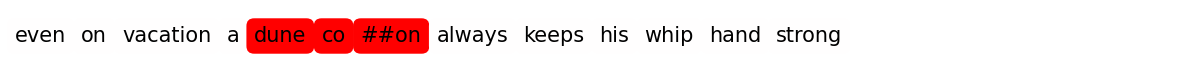

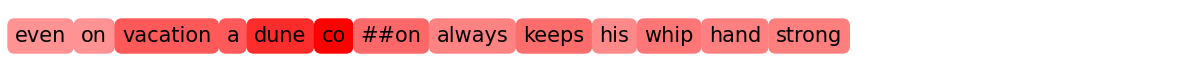

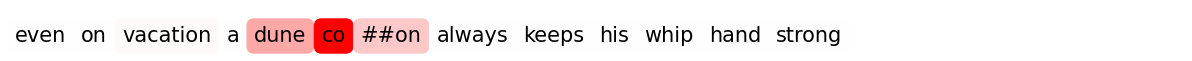

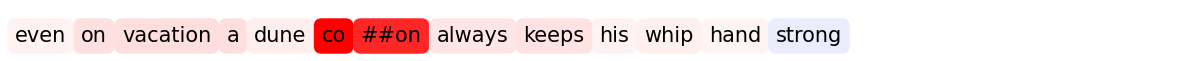

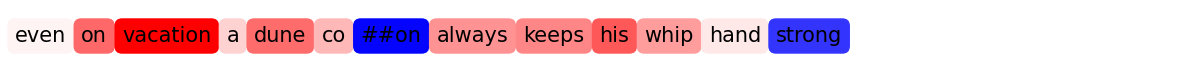

In [72]:
import matplotlib.pyplot as plt
from matplotlib import cm, transforms

ind = 504  #897

test_rational = test_test_rationales[ind]
instance = test_texts[ind]
my_evaluators.clear_states()
prediction, attention, hidden_states = model.my_predict(instance)
enc = model.tokenizer([instance, instance], truncation=True, padding=True)[0]
mask = enc.attention_mask
tokens = enc.tokens

print(prediction)
print('Original:')
plot_text_heatmap(tokens[1:-1], np.array(test_test_rationales[ind][1]))

my_explainers.config = conf[0]
temp = my_explainers.my_attention(instance, prediction, tokens, mask,
                                  attention, hidden_states)
interpretation = [maxabs_scale(i) for i in temp][1]
plot_text_heatmap(tokens[1:-1], np.array(interpretation))

my_explainers.config = conf[1]
temp = my_explainers.my_attention(instance, prediction, tokens, mask,
                                  attention, hidden_states)
interpretation = [maxabs_scale(i) for i in temp][1]
plot_text_heatmap(tokens[1:-1], np.array(interpretation))

temp = my_explainers.ig(instance, prediction, tokens, mask, attention,
                        hidden_states)
interpretation = [maxabs_scale(i) for i in temp][1]
plot_text_heatmap(tokens[1:-1], np.array(interpretation))

temp = my_explainers.lime(instance, prediction, tokens, mask, attention,
                          hidden_states)
interpretation = [maxabs_scale(i) for i in temp][1]
plot_text_heatmap(tokens[1:-1], np.array(interpretation))
